In [1]:
import numpy as np
rng = np.random.default_rng(seed = 37)

import matplotlib.pyplot as plt
import os

import torch as t
import torchvision as tv
from torchvision.transforms import v2

from tqdm import tqdm

import sys
sys.path.append('utils')

device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")
print(f'Using {device} for inference')

Using cpu for inference


In [27]:
ENV2 = tv.models.efficientnet_v2_s(weights = tv.models.EfficientNet_V2_S_Weights.DEFAULT).to(device)
ENV2.eval();
for param in ENV2.parameters():
    param.requires_grad = False
inference_transform = tv.models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()
inference_transforms = v2.Compose([
    lambda x: x.convert('RGB'),
    inference_transform,
])
visualization_transforms = v2.Compose(
    [v2.ToImage(),
     v2.ToDtype(t.float32, scale=True),
     v2.Resize(256),
     v2.CenterCrop(224),
     ])

In [28]:
fav_pic_index = 28621
data_root = 'imagenet'
imagenet_val_visual = tv.datasets.ImageNet(data_root, split = 'val', transform = visualization_transforms)
imagenet_val_inference = tv.datasets.ImageNet(data_root, split = 'val', transform = inference_transforms)
fav_image = imagenet_val_visual[fav_pic_index][0]

In [31]:
# from distortion import sparse_transform_amplitude, create_grid_sample, find_inv_grid, jacobian_det, get_version
from utils.diffeo_container import sparse_diffeo_container

In [46]:
sparse_diffeos = sparse_diffeo_container(224, 224)
sparse_diffeos.sparse_AB_append(5, 5, 3, 0.1, 10)
sparse_diffeos.get_all_grid()
diffeo_composed = sparse_diffeos.get_composition(level = 1)
diffeo_composed.up_down_sample(56, 56)
diffeo_composed.up_down_sample(28, 28)
diffeo_composed.up_down_sample(14, 14)
diffeo_composed.up_down_sample( 7,  7)
index_dict = diffeo_composed.element_to_index

In [47]:
ToImage = v2.ToPILImage()
distorted_image = t.nn.functional.grid_sample(fav_image.unsqueeze(0).repeat(len(diffeo_composed[2]),1,1,1), diffeo_composed[2], mode = 'bilinear')

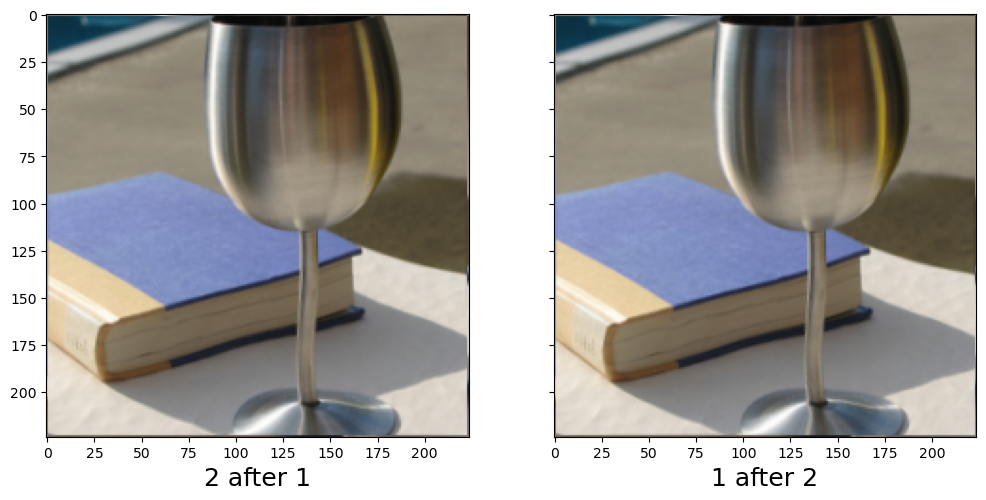

In [48]:
index_dict['g1g2'][1]
fig, axes = plt.subplots(1,2, figsize = (12,6), sharey=True)
axes[0].imshow(ToImage(distorted_image[index_dict['g2g1'][1]]));
axes[0].set_xlabel('2 after 1', fontsize=18);
axes[1].imshow(ToImage(distorted_image[index_dict['g1g2'][1]]));
axes[1].set_xlabel('1 after 2', fontsize=18);

# cax = axes[3].matshow(t.linalg.vector_norm((distorted_again - fav_image.unsqueeze(0)).squeeze(), dim = 0));
# axes[3].set_xlabel(r'|A|=1', fontsize=18);
# fig.colorbar(cax)

In [29]:
activation = {}
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
handles = []

def retrieve_layer_activation(model, input, layer_index):
  if len(input) == 3: input = input[None, :, :, :]

  layers = list(model.children())
  layers_flat = flatten(layers)

  for index in layer_index:
    handles.append(layers_flat[index - 1].register_forward_hook(getActivation(str(index))))

  with t.no_grad(): model(input)
  for handle in handles: handle.remove()

  return

def flatten(array):
    result = []
    for element in array:
        if hasattr(element, "__iter__"):
            result.extend(flatten(element))
        else:
            result.append(element)
    return result

In [ ]:
#path = '/content/drive/Shareddrives/Diffeomorphisms_&_CNNs/Alex/data/'
#t.save(grid_sample, path + '20-50-10-10-3-224-224_grid_sample.pt')
last_layer_activation = []
imagenet_val_loader = iter(t.utils.data.DataLoader(imagenet_val_inference, batch_size = 1, shuffle=False))
for i in tqdm(range(100)):
  #file_prefix = f'20-50-10-10-3-224-224_image-{i:04d}_activation'
  val_image, _ = next(imagenet_val_loader)
  distorted_list = t.nn.functional.grid_sample(val_image.repeat(amp_steps * diffeo_num,1,1,1), grid_sample, mode = 'bilinear').to(device)
  retrieve_layer_activation(ENV2, distorted_list, [49])
  last_layer_activation.append(activation['49'])
  activation = {}
  handle = []
